# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [6]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  11.1M      0  0:00:17  0:00:17 --:--:-- 15.9M


In [7]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

Text(0.5, 1.0, 'Galaxy IDX 9 ')

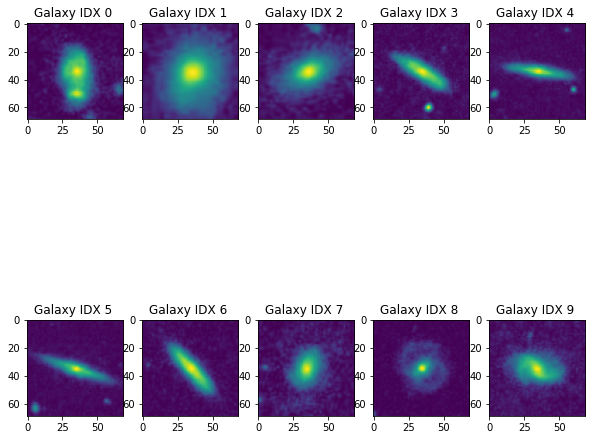

In [8]:
import random
np.random.seed(0) 
def random_index_finder(labels, idx):
    desired_indices = np.where(np.argmax(labels[:]-1, axis=1)==idx)
    return random.choice(desired_indices[0])

fig, axs = plt.subplots(2, 5, figsize=(10,10))
axs = axs.ravel()
axs[0].imshow(images[random_index_finder(labels, 0)][:,:,0])
axs[0].set_title('Galaxy IDX 0 ')
axs[1].imshow(images[random_index_finder(labels, 1)][:,:,0])
axs[1].set_title('Galaxy IDX 1 ')
axs[2].imshow(images[random_index_finder(labels, 2)][:,:,0])
axs[2].set_title('Galaxy IDX 2 ')
axs[3].imshow(images[random_index_finder(labels, 3)][:,:,0])
axs[3].set_title('Galaxy IDX 3 ')
axs[4].imshow(images[random_index_finder(labels, 4)][:,:,0])
axs[4].set_title('Galaxy IDX 4 ')
axs[5].imshow(images[random_index_finder(labels, 5)][:,:,0])
axs[5].set_title('Galaxy IDX 5 ')
axs[6].imshow(images[random_index_finder(labels, 6)][:,:,0])
axs[6].set_title('Galaxy IDX 6 ')
axs[7].imshow(images[random_index_finder(labels, 7)][:,:,0])
axs[7].set_title('Galaxy IDX 7 ')
axs[8].imshow(images[random_index_finder(labels, 8)][:,:,0])
axs[8].set_title('Galaxy IDX 8 ')
axs[9].imshow(images[random_index_finder(labels, 9)][:,:,0])
axs[9].set_title('Galaxy IDX 9 ')



Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

In [9]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


11501568/11490434 [==============================] - 0s 0us/step


In [10]:
np.sum(labels,axis=0)

array([3461., 6997., 6292.,  349., 1534.,   17.,  589., 1121.,  906.,
        519.], dtype=float32)

In [11]:
labels_hist =[]
for i,j in enumerate(np.sum(labels,axis=0)):
    for _ in range(int(j)):
        labels_hist.append(i)


Text(0.5, 1.0, 'GALAXY DATA HIST')

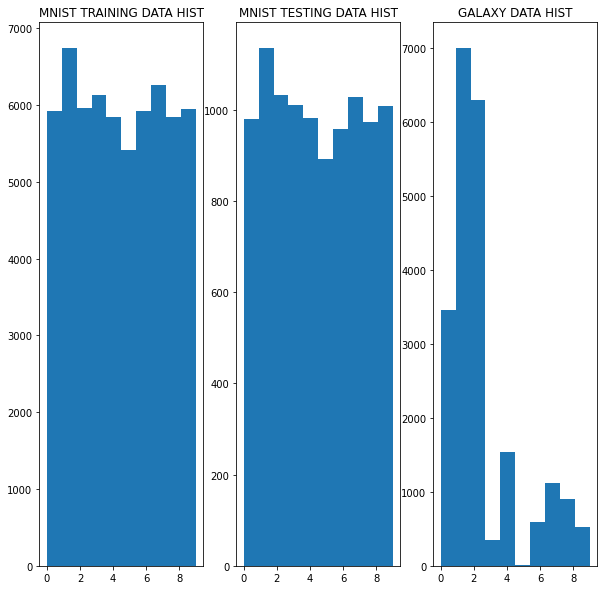

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].hist(y_train)
axs[0].set_title('MNIST TRAINING DATA HIST')
axs[1].hist(y_test)
axs[1].set_title('MNIST TESTING DATA HIST')
axs[2].hist((labels_hist))
axs[2].set_title('GALAXY DATA HIST')


The data in MNIST is more uniformly distributed than in the galaxy dataset. There are aproximately 10000 of each type of digit in the traininset whereas there are only 17 examples of index 5 galaxies. I guess galaxies don't have equal probability of being formed.

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [13]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_rem, y_train, y_rem = train_test_split(images, labels, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#Taken from here https://www.tensorflow.org/guide/keras/sequential_model
model = keras.Sequential()
model.add(keras.Input(shape=(69, 69, 3)))  # 250x250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, 2, activation="relu"))
model.add(layers.Conv2D(32, 2, activation="relu"))
model.add(layers.MaxPooling2D(2))

# Now that we have 4x4 feature maps, time to apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add a classification layer.
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 33, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 32)          4128      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid))


Epoch 1/100
273/273 [==============================] - 16s 16ms/step - loss: 7.9963 - accuracy: 0.1496 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 2/100
273/273 [==============================] - 4s 13ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 3/100
273/273 [==============================] - 4s 13ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 4/100
273/273 [==============================] - 4s 13ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 5/100
273/273 [==============================] - 4s 13ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 6/100
273/273 [==============================] - 4s 14ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy: 0.1364
Epoch 7/100
273/273 [==============================] - 4s 13ms/step - loss: 8.0822 - accuracy: 0.1306 - val_loss: 7.8740 - val_accuracy

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [16]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 0s 5ms/step - loss: 8.3438 - accuracy: 0.1198


[8.343833923339844, 0.11977971345186234]

In [17]:
predictions = model(X_test)

In [18]:
prediction_probabilities = tf.nn.softmax(predictions,axis=0).numpy()
# predictions

In [19]:
def one_hot_decoder(array):
  decoded_array = np.zeros(len(array))
  for i in range(len(array)):
    decoded_array[i] = np.argmax(array[i])
  return decoded_array

In [20]:
decoded_y_test = one_hot_decoder(y_test)
decoded_prediction_probabilities = one_hot_decoder(prediction_probabilities)

In [21]:
tf.math.confusion_matrix(
    decoded_y_test,
    decoded_prediction_probabilities)


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 68,   0,   0,   8,  69,   3,  10,  44,   0, 126],
       [215,   0,   1,  51, 264,   0,   4,  78,   0, 139],
       [191,   1,   0,  41, 242,   1,  17,  41,   0,  76],
       [  6,   0,   0,   3,   5,   1,   0,   5,   0,   9],
       [ 50,   0,   0,  18,  16,   0,  20,  12,   0,  25],
       [  3,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  6,   0,   0,  18,   0,   1,   0,  17,   0,  15],
       [ 27,   0,   0,   1,  29,   0,   0,  28,   0,  39],
       [  8,   0,   0,   1,  11,   0,   1,  21,   0,  43],
       [  7,   0,   0,   6,   4,   0,   0,  12,   0,  20]], dtype=int32)>

There seems to be an abundance of guesses for the fourth index/fifth galaxy type which doesn't make too much sense when looking at the distribution of galaxies. It looks like the network I copied off the tensorflow site hasn't been well tuned to our problem/isn't learning at all. :

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

In [25]:
images = images/np.max(images) #Send data to [0,1]

In [26]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_rem, y_train, y_rem = train_test_split(images, labels, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid))


Epoch 1/100
273/273 [==============================] - 6s 19ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 2/100
273/273 [==============================] - 4s 16ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 3/100
273/273 [==============================] - 4s 14ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 4/100
273/273 [==============================] - 4s 13ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 5/100
273/273 [==============================] - 4s 13ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 6/100
273/273 [==============================] - 4s 13ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy: 0.0932
Epoch 7/100
273/273 [==============================] - 4s 13ms/step - loss: 8.2496 - accuracy: 0.0920 - val_loss: 8.0961 - val_accuracy:

In [28]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 0s 7ms/step - loss: 8.4622 - accuracy: 0.0932


[8.462187767028809, 0.09316200017929077]

My randomly created network is still not well tuned for this problem. We still have random chance classification.

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

In [36]:
from tensorflow.keras.models import Sequential

img_height, img_width = 69, 69
num_classes = 10
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [38]:
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid))


Epoch 1/100
273/273 [==============================] - 9s 22ms/step - loss: 7.4119 - accuracy: 0.3142 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 2/100
273/273 [==============================] - 6s 20ms/step - loss: 7.3173 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 3/100
273/273 [==============================] - 5s 20ms/step - loss: 7.3053 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 4/100
273/273 [==============================] - 5s 20ms/step - loss: 7.3192 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 5/100
273/273 [==============================] - 5s 20ms/step - loss: 7.3072 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 6/100
273/273 [==============================] - 5s 20ms/step - loss: 7.3099 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy: 0.3269
Epoch 7/100
273/273 [==============================] - 5s 20ms/step - loss: 7.3127 - accuracy: 0.3175 - val_loss: 7.4744 - val_accuracy:

In [39]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 0s 7ms/step - loss: 7.7447 - accuracy: 0.3451


[7.744675636291504, 0.3451124429702759]

The best model was the copied network architecture from https://www.tensorflow.org/tutorials/images/classification. The inability for the network to learn between epochs is also present in this model, and I'm unsure why this is the case. This image captures what it feels like to put together a neural network architecture. 
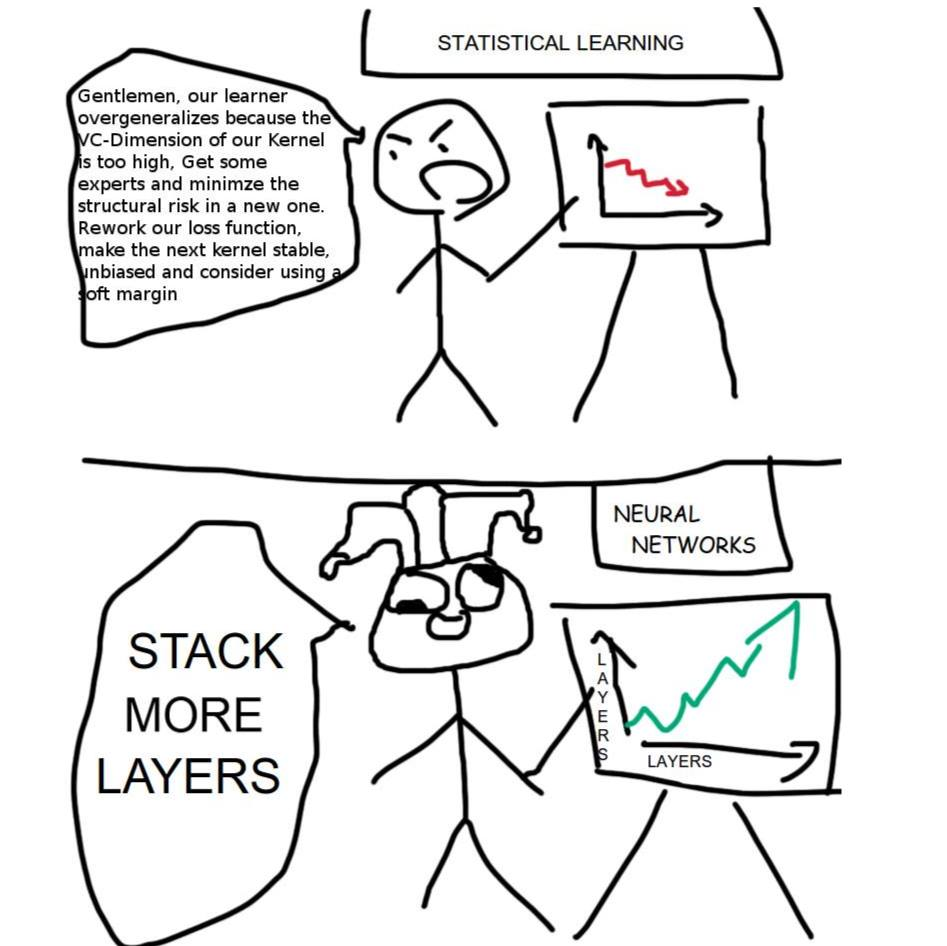

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [148]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 512

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0


Make a simple autoencoder

In [149]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-06T00:17.h5
Epoch 1/10
467/469 [============================>.] - ETA: 0s - loss: 0.0298
Epoch 1: val_loss improved from inf to 0.02256, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T00:17.h5
469/469 [==============================] - 10s 19ms/step - loss: 0.0298 - val_loss: 0.0226
Epoch 2/10
466/469 [============================>.] - ETA: 0s - loss: 0.0182
Epoch 2: val_loss improved from 0.02256 to 0.01702, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T00:17.h5
469/469 [==============================] - 6s 13ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 3/10
465/469 [============================>.] - ETA: 0s - loss: 0.0164
Epoch 3: val_loss improved from 0.01702 to 0.01570, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T00:17.h5
469/469 [==============================] - 6s 13ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 4/10
466/469 [============================>.] - ETA: 0s - loss: 0.0155


In [150]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-06T00:17.h5


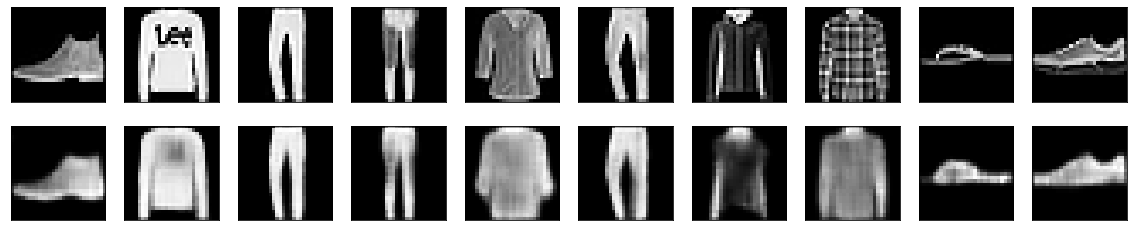

In [151]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

In [152]:
from sklearn.ensemble import RandomForestClassifier


In [153]:
#FROM https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer we create a encoding layer for our random forest model. 
# autoencoder.summary()
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer('bottleneck').output)
# intermediate_layer_model.summary()


In [154]:
intermediate_output = intermediate_layer_model.predict(x_train)
print(intermediate_output.shape)

(60000, 512)


In [155]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(intermediate_output, Y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [156]:
test_encodings = intermediate_layer_model.predict(x_test)
predicted_classes = clf.predict(test_encodings)

In [157]:
def score(prediction, guess):
  count = 0
  for i in range(len(prediction)):
    if np.argmax(prediction[i]) == np.argmax(guess[i]):
      count+=1
  return count/len(prediction)

In [158]:
score(predicted_classes, Y_test)

0.1634

We get better results than random chance! Results are better than my random arranged neural network, but does not perform as well as the tensorflow example network. I need to do more tuning...

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

These are the classification percentages from different bottleneck sizes:

SIZE OF LAYER: CLASSIFICATION PERCENT

4: 0.145

16: 0.1

32: 0.1

64: 0.1927

128: 0.1684

256: 0.1746

512: 0.1634

64+ units seems to be the right number for my poorly tuned random forest.